Note: sesuaikan semua `/path/to/` menuju directory yang sesuai

# Installs

In [ ]:
!pip install -U tensorflow scikit-learn nervaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.2 kB/s 
     |████████████████████████████████| 5.8 MB 46.6 MB/s 
     |████████████████████████████████| 1.6 MB 41.1 MB/s 
     |████████████████████████████████| 438 kB 73.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

# Imports

In [ ]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

from gensim import models

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras import Sequential, Model
from keras.layers import TimeDistributed, Dense, LSTM, Bidirectional, Embedding, Input, Lambda, Reshape, RepeatVector
import keras.backend as K
from keras.models import load_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11530337020609633838
xla_global_id: -1
]
Default GPU Device: 


# Load Data

In [ ]:
df_atis_test = pd.read_csv('https://raw.githubusercontent.com/moore3930/SlotRefine/main/data/atis/test/data', header=None, sep="\t", names=["data", "encoding", "ground_truth"])
df_atis_train = pd.read_csv('https://raw.githubusercontent.com/moore3930/SlotRefine/main/data/atis/train/data', header=None, sep="\t", names=["data", "encoding", "ground_truth"])
df_atis_val = pd.read_csv('https://raw.githubusercontent.com/moore3930/SlotRefine/main/data/atis/valid/data', header=None, sep="\t", names=["data", "encoding", "ground_truth"])

df_snips_test = pd.read_csv('https://raw.githubusercontent.com/moore3930/SlotRefine/main/data/snips/test/data', header=None, sep="\t", names=["data", "encoding", "ground_truth"])
df_snips_train = pd.read_csv('https://raw.githubusercontent.com/moore3930/SlotRefine/main/data/snips/train/data', header=None, sep="\t", names=["data", "encoding", "ground_truth"])
df_snips_val = pd.read_csv('https://raw.githubusercontent.com/moore3930/SlotRefine/main/data/snips/valid/data', header=None, sep="\t", names=["data", "encoding", "ground_truth"])

In [ ]:
df_snips_concat = pd.concat([df_snips_train, df_snips_val, df_snips_test])
np.unique(df_snips_concat.ground_truth)

In [ ]:
from functools import reduce
TAGS = np.unique(list(reduce(lambda x,y:x+y, map(lambda x:x.split(), df_snips_concat.encoding))))
TAGS

In [ ]:
NUM_TAGS = len(TAGS)
NUM_TAGS

In [ ]:
df_snips_concat.head()["data"][0]

In [ ]:
df_snips_concat.head()

In [ ]:
len(sorted(df_snips_concat.data, key=lambda x:len(x.split(" ")))[-1])

In [ ]:
np.unique(df_snips_train.ground_truth)

Uncomment this if using Google Drive and Google Colab

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Model Word2Vec LSTM

## Word2Vec dan Data Preprocessing

Link model word2vec: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g

In [ ]:
word2vec = models.KeyedVectors.load_word2vec_format(
    '/path/to/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
# refer to https://towardsdatascience.com/pos-tagging-using-rnn-7f08a522f849
# and https://www.kaggle.com/code/tanyadayanand/pos-tagging-using-rnn/notebook

def tokenize(seqs, oov_token=None):
  tokenizer = Tokenizer(oov_token=oov_token, split=" ", filters='')
  tokenizer.fit_on_texts(seqs)
  return tokenizer, tokenizer.texts_to_sequences(seqs)

In [ ]:
word_tokenizer, X_train_encoded = tokenize(df_snips_train.data)
tag_tokenizer, Y_train_encoded = tokenize(df_snips_train.encoding, oov_token="o")

In [ ]:
NUM_CLASSES = len(tag_tokenizer.word_index) + 2

In [ ]:
X_test_encoded = word_tokenizer.texts_to_sequences(df_snips_test.data)
Y_test_encoded = tag_tokenizer.texts_to_sequences(df_snips_test.encoding)
X_val_encoded = word_tokenizer.texts_to_sequences(df_snips_val.data)
Y_val_encoded = tag_tokenizer.texts_to_sequences(df_snips_val.encoding)

In [ ]:
MAX_SEQ_LENGTH = 256

X_train_padded = pad_sequences(X_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_train_padded = pad_sequences(Y_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
X_test_padded = pad_sequences(X_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_test_padded = pad_sequences(Y_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
X_val_padded = pad_sequences(X_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_val_padded = pad_sequences(Y_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_train_categorical = to_categorical(Y_train_padded, num_classes=NUM_CLASSES)
Y_test_categorical = to_categorical(Y_test_padded, num_classes=NUM_CLASSES)
Y_val_categorical = to_categorical(Y_val_padded, num_classes=NUM_CLASSES)

In [ ]:
intent_encoder = LabelBinarizer().fit(df_snips_train.ground_truth)
Y_train_intent = intent_encoder.transform(df_snips_train.ground_truth)
Y_test_intent = intent_encoder.transform(df_snips_test.ground_truth)
Y_val_intent = intent_encoder.transform(df_snips_val.ground_truth)

In [ ]:
INTENT_CLASSES = len(np.unique(df_snips_train.ground_truth))

In [ ]:
EMBEDDING_SIZE  = 300  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

In [ ]:
# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

## Membuat Kerangka Model

In [ ]:
EMBEDDING_SIZE = 300
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

w2v_model = Sequential()

In [ ]:
w2v_model.add(Input(shape=(MAX_SEQ_LENGTH,)))

# vocabulary size — number of unique words in data
# length of vector with which each word is represented
w2v_model.add(Embedding(input_dim = VOCABULARY_SIZE, 
  output_dim = EMBEDDING_SIZE, 
# length of input sequence
  input_length = MAX_SEQ_LENGTH, 
# word embedding matrix
  weights = [embedding_weights],
# True — update embeddings_weight matrix
  trainable = False 
))

In [ ]:
w2v_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(EMBEDDING_SIZE,1)))
w2v_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
w2v_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

w2v_model.build(input_shape=(EMBEDDING_SIZE, 1))
w2v_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 300)          3425700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 256)         439296    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 256, 74)          19018     
 tributed)                                                       
                                                                 
Total params: 3,884,014
Trainable params: 458,314
Non-trainable params: 3,425,700
_________________________________________________________________


## Training model Argument/POS

In [ ]:
Y_train_categorical[13083].shape

(256, 74)

In [ ]:
X_train_padded[13083].shape

(256,)

In [ ]:
history = w2v_model.fit(X_train_padded, Y_train_categorical, batch_size=256, epochs=20, validation_data=(X_val_padded, Y_val_categorical))

Epoch 1/20
52/52 [==============================] - 209s 4s/step - loss: 0.9073 - categorical_accuracy: 0.9633 - val_loss: 0.1027 - val_categorical_accuracy: 0.9794
Epoch 2/20
52/52 [==============================] - 197s 4s/step - loss: 0.0942 - categorical_accuracy: 0.9806 - val_loss: 0.0915 - val_categorical_accuracy: 0.9797
Epoch 3/20
52/52 [==============================] - 202s 4s/step - loss: 0.0839 - categorical_accuracy: 0.9815 - val_loss: 0.0842 - val_categorical_accuracy: 0.9802
Epoch 4/20
52/52 [==============================] - 200s 4s/step - loss: 0.0737 - categorical_accuracy: 0.9831 - val_loss: 0.0756 - val_categorical_accuracy: 0.9824
Epoch 5/20
52/52 [==============================] - 205s 4s/step - loss: 0.0621 - categorical_accuracy: 0.9854 - val_loss: 0.0665 - val_categorical_accuracy: 0.9841
Epoch 6/20
52/52 [==============================] - 202s 4s/step - loss: 0.0513 - categorical_accuracy: 0.9876 - val_loss: 0.0592 - val_categorical_accuracy: 0.9856
Epoch 7/20

In [ ]:
w2v_model.add(Lambda(lambda x: K.argmax(x)))

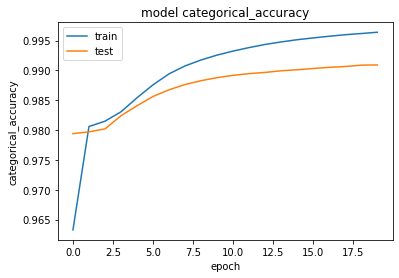

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model categorical_accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

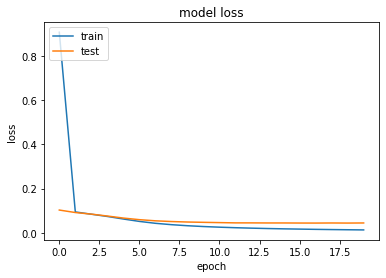

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = w2v_model.predict(X_test_padded)

22/22 [==============================] - 9s 356ms/step


In [ ]:
y_pred_dec = list(map(lambda x: tag_tokenizer.sequences_to_texts([x[0][-len(x[1]):]])[0],
                      zip(y_pred, Y_test_encoded)))

In [ ]:
Y_test_encoded[:5]

[[2, 12, 13, 2, 2, 8, 4, 2],
 [2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 18, 2, 63, 2, 2, 16, 2],
 [2, 12, 13, 2, 20, 8, 4, 4, 4, 4, 4, 4, 4],
 [2, 2, 42, 2, 24, 2, 9, 7, 7],
 [2, 12, 13, 14, 2, 2, 2, 38]]

In [ ]:
tag_tokenizer.sequences_to_texts(Y_test_encoded)[:5]

['o b-artist i-artist o o b-playlist i-playlist o',
 'o o o o b-party_size_number o o o o o o b-spatial_relation o b-poi o o b-restaurant_type o',
 'o b-artist i-artist o b-playlist_owner b-playlist i-playlist i-playlist i-playlist i-playlist i-playlist i-playlist i-playlist',
 'o o b-condition_description o b-state o b-timerange i-timerange i-timerange',
 'o b-artist i-artist b-music_item o o o b-sort']

In [ ]:
y_pred_dec[:5]

['o o o o o b-playlist i-playlist o',
 'o o o o b-party_size_number o o o o o o b-spatial_relation o o o o b-served_dish o',
 'o o o o b-playlist_owner b-playlist i-playlist i-playlist i-playlist i-playlist i-playlist i-playlist o',
 'o o b-condition_description o b-state o b-timerange i-timerange i-timerange',
 'o o b-artist b-music_item o o o b-sort']

## Intent Detection

In [ ]:
intent_model = Sequential(w2v_model)
intent_model.layers[0].trainable = False
intent_model.add(Lambda(lambda x:tf.cast(x, tf.float32)))
intent_model.add(Reshape((MAX_SEQ_LENGTH, 1)))
intent_model.add(Bidirectional(LSTM(100), input_shape=(MAX_SEQ_LENGTH, 1)))
intent_model.add(Dense(INTENT_CLASSES, activation='softmax'))

In [ ]:
intent_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256)               3884014   
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 256, 1)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              81600     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 7)                 1407      
                                                                 
Total params: 3,967,021
Trainable params: 83,007
Non-trainable params: 3,884,014
_______________________________________

In [ ]:
intent_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [ ]:
history_intent = intent_model.fit(X_train_padded, Y_train_intent, batch_size=256, epochs=20, validation_data=(X_val_padded, Y_val_intent))

Epoch 1/20
52/52 [==============================] - 226s 4s/step - loss: 1.6216 - categorical_accuracy: 0.3801 - val_loss: 1.4276 - val_categorical_accuracy: 0.4771
Epoch 2/20
52/52 [==============================] - 165s 3s/step - loss: 1.2844 - categorical_accuracy: 0.5145 - val_loss: 1.2675 - val_categorical_accuracy: 0.5557
Epoch 3/20
52/52 [==============================] - 159s 3s/step - loss: 1.1387 - categorical_accuracy: 0.5798 - val_loss: 1.1571 - val_categorical_accuracy: 0.5814
Epoch 4/20
52/52 [==============================] - 159s 3s/step - loss: 1.0283 - categorical_accuracy: 0.6325 - val_loss: 1.0686 - val_categorical_accuracy: 0.6486
Epoch 5/20
52/52 [==============================] - 160s 3s/step - loss: 0.9406 - categorical_accuracy: 0.6708 - val_loss: 0.9901 - val_categorical_accuracy: 0.6829
Epoch 6/20
52/52 [==============================] - 158s 3s/step - loss: 0.8554 - categorical_accuracy: 0.7083 - val_loss: 0.9352 - val_categorical_accuracy: 0.6943
Epoch 7/20

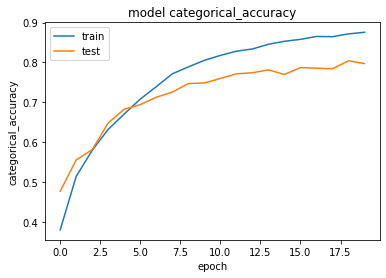

In [ ]:
plt.plot(history_intent.history['categorical_accuracy'])
plt.plot(history_intent.history['val_categorical_accuracy'])
plt.title('model categorical_accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

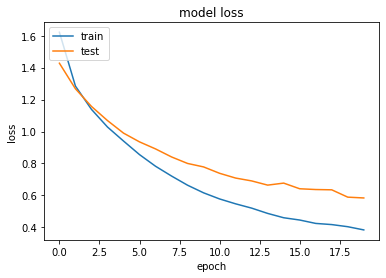

In [ ]:
plt.plot(history_intent.history['loss'])
plt.plot(history_intent.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred_intent = intent_model.predict(X_test_padded)

22/22 [==============================] - 11s 422ms/step


In [ ]:
y_pred_intent[:5]

array([[8.0474205e-02, 2.4726626e-03, 5.3862561e-03, 4.1110569e-01,
        4.0692990e-03, 4.3747732e-01, 5.9014563e-02],
       [9.8491004e-03, 9.2466974e-01, 4.6741571e-02, 1.0644792e-02,
        3.4311640e-03, 2.7279137e-04, 4.3905973e-03],
       [8.2624280e-01, 7.3436303e-03, 2.4813111e-03, 1.6188836e-02,
        7.6455496e-02, 6.8861477e-02, 2.4263235e-03],
       [1.6596513e-02, 5.2867644e-02, 9.1592354e-01, 9.2117768e-03,
        2.6537255e-05, 2.1804431e-04, 5.1558642e-03],
       [2.5361967e-03, 1.5544054e-02, 1.8510805e-03, 9.6118647e-01,
        9.7201318e-03, 4.5929779e-04, 8.7027056e-03]], dtype=float32)

In [ ]:
y_pred_intent_dec = intent_encoder.inverse_transform(y_pred_intent)

In [ ]:
y_pred_intent_dec[:5]

array(['SearchCreativeWork', 'BookRestaurant', 'AddToPlaylist',
       'GetWeather', 'PlayMusic'], dtype='<U20')

## Menyimpan Model

In [ ]:
w2v_model.save('/path/to/LSTM/SNIPS/Tag/')
intent_model.save('/path/to/LSTM/SNIPS/Intent/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Manusia Learning/LSTM/SNIPS/Tag/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Manusia Learning/LSTM/SNIPS/Tag/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Manusia Learning/LSTM/SNIPS/Intent/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Manusia Learning/LSTM/SNIPS/Intent/assets


Sumber: https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring

In [ ]:
# saving word_tokenizer
with open('/path/to/LSTM/SNIPS/word_tokenizer_w2vLSTM.pickle', 'wb') as handle:
    pickle.dump(word_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving tag_tokenizer
with open('/path/to/LSTM/SNIPS/tag_tokenizer_w2vLSTM.pickle', 'wb') as handle:
    pickle.dump(tag_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving intent encoder
with open('/path/to/LSTM/SNIPS/intent_encoder_w2vLSTM.pickle', 'wb') as handle:
    pickle.dump(intent_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load model

Sebelum menjalankan ini, jalankan dahulu bagian `Installs` dan `Imports`

Sesuaikan path di bawah ini dengan path menuju folder yang sesuai. Silakan merujuk pada link https://drive.google.com/drive/folders/105ETAA9leXX3tQfJ1pWKGJgV_uf0R91j?usp=sharing untuk struktur folder.

In [ ]:
with open('/path/to/LSTM/SNIPS/word_tokenizer_w2vLSTM.pickle', 'rb') as handle:
  word_tokenizer_load = pickle.load(handle)

In [ ]:
with open('/path/to/LSTM/SNIPS/tag_tokenizer_w2vLSTM.pickle', 'rb') as handle:
  tag_tokenizer_load = pickle.load(handle)

In [ ]:
with open('/path/to/LSTM/SNIPS/intent_encoder_w2vLSTM.pickle', 'rb') as handle:
  intent_encoder_load = pickle.load(handle)

In [ ]:
load_w2v_model = load_model("/path/to/LSTM/SNIPS/Tag")
load_intent_model = load_model("/path/to/LSTM/SNIPS/Intent")

In [ ]:
with open('/path/to/LSTM/SNIPS/intent_encoder_w2vLSTM.pickle', 'rb') as handle:
  intent_encoder_load = pickle.load(handle)

In [ ]:
def get_args(w2v_pred_dec, string):
  curr_phrase_tag = ''
  args = []
  for tag, token in zip(w2v_pred_dec.split(" "), string.split(" ")):
    if tag == 'o':
      curr_phrase_tag = ''
      continue
    elif not tag.startswith(('b-', 'i-')):
      args.append([tag, token])
      curr_phrase_tag = ''
    elif tag.startswith('b-'):
      curr_phrase_tag = tag[2:]
      args.append([curr_phrase_tag, token])
    else:
      if tag[2:] == curr_phrase_tag:
        args[-1][1] += f" {token}"
  return args

In [ ]:
def nlu(string, word_tokenizer, tag_tokenizer, w2v_model, intent_model, intent_encoder, max_seq_length = 256):
  str_enc = word_tokenizer.texts_to_sequences([string])
  str_pad = pad_sequences(str_enc, maxlen=max_seq_length, padding="pre", truncating="post")
  w2v_pred = w2v_model.predict(str_pad)
  intent_pred = intent_model.predict(str_pad)
  w2v_pred_dec = list(map(lambda x: tag_tokenizer.sequences_to_texts([x[0][-len(x[1]):]])[0],
                      zip(w2v_pred, [string.split(" ")])))
  intent_pred_dec = intent_encoder.inverse_transform(intent_pred)
  return {'args': get_args(w2v_pred_dec[0], string), 'intent': intent_pred_dec[0]}

In [ ]:
nlu('add nothing fancy to meditate to sounds of nature playlist', word_tokenizer_load, tag_tokenizer_load, load_w2v_model, load_intent_model, intent_encoder_load)

1/1 [==============================] - 0s 99ms/step


{'args': [['entity_name', 'fancy to meditate']], 'intent': 'AddToPlaylist'}

# Evaluasi

## F1 Score Model Word2Vec LSTM

In [ ]:
from functools import reduce
tags = np.unique(list(map(lambda x:x[2:], filter(lambda x:x!="O", reduce(lambda x, y: x+y.split(" "), df_snips_test.encoding, [])))))

In [ ]:
from nervaluate import Evaluator

res, res_type = Evaluator(list(map(lambda x:x.split(" "), tag_tokenizer.sequences_to_texts(Y_test_encoded))), list(map(lambda x:x.split(" "), y_pred_dec)), tags=tags, loader="list").evaluate()

In [ ]:
pd.DataFrame(res)

ent_type      partial       strict        exact
correct    1233.000000  1049.000000   985.000000  1049.000000
incorrect   182.000000     0.000000   430.000000   366.000000
partial       0.000000   366.000000     0.000000     0.000000
missed      268.000000   268.000000   268.000000   268.000000
spurious    272.000000   272.000000   272.000000   272.000000
possible   1683.000000  1683.000000  1683.000000  1683.000000
actual     1687.000000  1687.000000  1687.000000  1687.000000
precision     0.730883     0.730290     0.583877     0.621814
recall        0.732620     0.732026     0.585264     0.623292
f1            0.731751     0.731157     0.584570     0.622552

## Intent Detection

In [ ]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(df_snips_test.ground_truth, y_pred_intent_dec, output_dict=True, zero_division=0)).transpose()

precision    recall  f1-score     support
AddToPlaylist          0.896000  0.903226  0.899598  124.000000
BookRestaurant         0.864198  0.760870  0.809249   92.000000
GetWeather             0.816092  0.682692  0.743455  104.000000
PlayMusic              0.558559  0.720930  0.629442   86.000000
RateBook               0.882353  0.937500  0.909091   80.000000
SearchCreativeWork     0.796460  0.841121  0.818182  107.000000
SearchScreeningEvent   0.857143  0.785047  0.819512  107.000000
accuracy               0.805714  0.805714  0.805714    0.805714
macro avg              0.810115  0.804484  0.804076  700.000000
weighted avg           0.815776  0.805714  0.807733  700.000000